In [1]:
import torch
import numpy as np
import yfinance as yf
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Baseline

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
time_steps = 5
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
learning_rate = 0.0004

Будем прогнозировать акции Apple

In [61]:
data = yf.download("AAPL", start=start_date, end=end_date)
data.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [62]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-01,5.710714,5.713929,5.562500,5.595000,4.749016,544639200
1,2008-08-04,5.592857,5.639286,5.461071,5.472500,4.645039,592527600
2,2008-08-05,5.550714,5.742857,5.529286,5.737143,4.869668,688371600
3,2008-08-06,5.713214,5.978571,5.642857,5.863929,4.977283,791408800
4,2008-08-07,5.811071,5.933929,5.767857,5.841786,4.958486,672372400


Предсказываемое значение - цена закрытия

In [63]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2008-08-01,5.595000
1,2008-08-04,5.472500
2,2008-08-05,5.737143
3,2008-08-06,5.863929
4,2008-08-07,5.841786
...,...,...
3769,2023-07-25,193.619995
3770,2023-07-26,194.500000
3771,2023-07-27,193.220001
3772,2023-07-28,195.830002


C:\Users\Михаил\AppData\Local\Temp\ipykernel_5928\1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


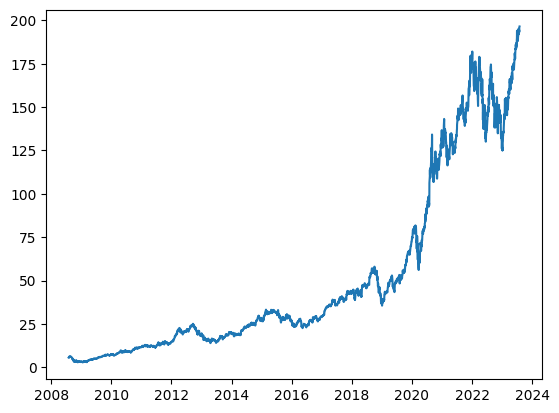

In [64]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [65]:
data.set_index('Date', inplace=True)

In [19]:
data

,Close
Date,
2008-08-01,5.595000
2008-08-04,5.472500
2008-08-05,5.737143
2008-08-06,5.863929
2008-08-07,5.841786
...,...
2023-07-25,193.619995
2023-07-26,194.500000
2023-07-27,193.220001


In [66]:
scale = MinMaxScaler(feature_range=(0, 1))
data_scaled = scale.fit_transform(data)

In [72]:
X_train, X_test = train_test_split(data_scaled, test_size=0.2, shuffle=False)

In [73]:
def make_timpesteps(X):
    x = []
    y = []
    for i in range(time_steps, X.shape[0]):
        x.append(X[i - time_steps:i])
        y.append(X[i, 0])
        
    # Изменение размерности и преобразование в тензоры
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    y = y.reshape((-1, 1))
    x = torch.tensor(x).float()
    y = torch.tensor(y).float()
    x = x.to(device)
    y = y.to(device)
    return x, y

In [74]:
x_train, y_train = make_timpesteps(X_train)

In [75]:
x_test, y_test = make_timpesteps(X_test)

In [76]:
x_train.shape

torch.Size([3014, 5, 1])

Подготовим данные

In [77]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

Разработаем baseline LSTM модель

In [78]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, dropout=0.2)
        
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

Обучение модели

In [79]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [80]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(valid_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [81]:
model = LSTM(1, 128, 3)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [82]:
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.000
***************************************************

Epoch: 2

Val Loss: 0.000
***************************************************

Epoch: 3

Val Loss: 0.000
***************************************************

Epoch: 4

Val Loss: 0.000
***************************************************

Epoch: 5

Val Loss: 0.000
***************************************************

Epoch: 6

Val Loss: 0.000
***************************************************

Epoch: 7

Val Loss: 0.000
***************************************************

Epoch: 8

Val Loss: 0.000
***************************************************

Epoch: 9

Val Loss: 0.000
***************************************************

Epoch: 10

Val Loss: 0.000
***************************************************

Epoch: 11

Val Loss: 0.000
***************************************************

Epoch: 12

Val Loss: 0.000
***************************************************

Epoch: 13

Val Loss: 0.000
**********************

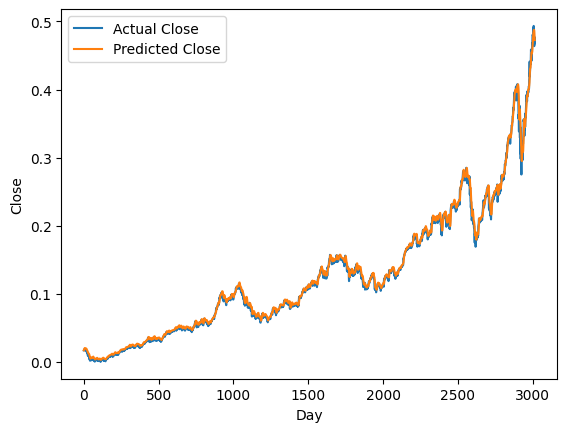

In [84]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train.to('cpu'), label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [86]:
from copy import deepcopy as dc

test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], time_steps+1))
dummies[:, 0] = test_predictions
dummies = scale.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions.shape


(750,)

In [87]:
dummies = np.zeros((x_test.shape[0], time_steps+1))
dummies[:, 0] = y_test.to('cpu').flatten()
dummies = scale.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test.shape

(750,)

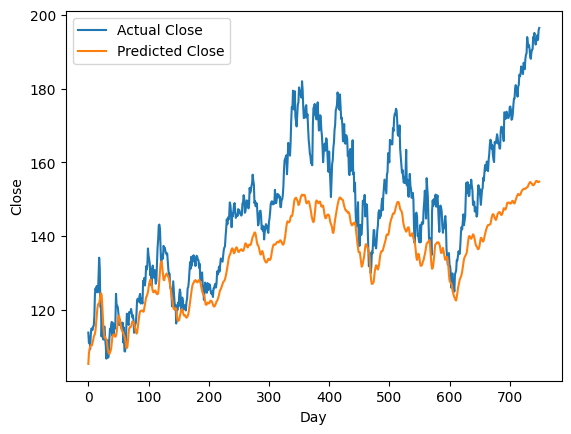

In [88]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_predictions, new_y_test, squared=True)
print('Test RMSE: %.3f' % error)

Test RMSE: 246.097
